In [1]:
from jax_circuits import *
from topology import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

# Learning random unitaries

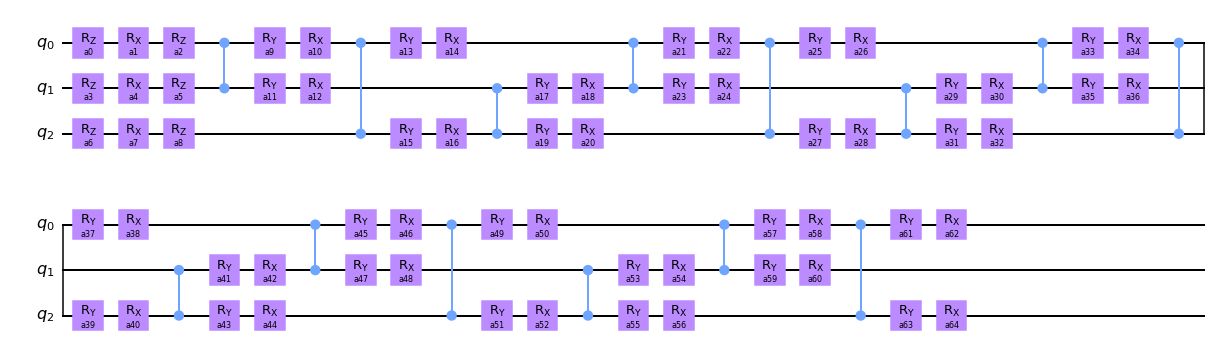

In [2]:
num_qubits = 3
depth = theoretical_lower_bound(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
anz.circuit().draw(output='mpl')

In [3]:
u_target = unitary_group.rvs(2**num_qubits, random_state=0)
angles_history, loss_history = anz.learn(u_target)

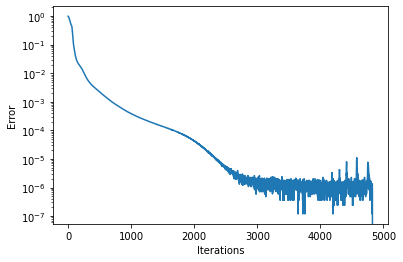

In [4]:
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.plot(loss_history)
plt.yscale('log')

## Restricted topology

In [5]:
num_qubits = 4
depth = theoretical_lower_bound(num_qubits)

anz_connected = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
anz_chain = Ansatz(num_qubits, 'cz', placements=fill_layers(chain_layer(num_qubits), depth))

u_target = unitary_group.rvs(2**num_qubits, random_state=0)

_, loss_history_connected = anz_connected.learn(u_target)
_, loss_history_chain = anz_chain.learn(u_target)

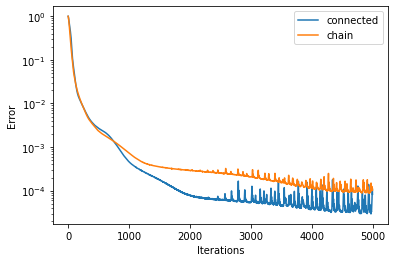

In [6]:
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.plot(loss_history_connected, label='connected')
plt.plot(loss_history_chain, label='chain')
plt.legend()
plt.yscale('log')

# State preparation

In [25]:
def state_tlb(n):
    return int((2**(n+1)-2*n-1)/4 + 1)

def state_learn(u, s_target, num_angles, **kwargs):
    all_zero_state = jnp.zeros(s_target.shape).at[0].set(1)
    def cost_func(angles):
        s_u = u(angles) @ all_zero_state
        return 1-(jnp.abs(s_u.conj()*s_target)).sum()
    
    return gradient_descent_learn(cost_func, num_angles, **kwargs)

In [30]:
%%time

num_qubits = 5
depth =  state_tlb(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))

state_target = unitary_group.rvs(2**num_qubits, random_state=42)[0]
angles_history, loss_history = state_learn(anz.unitary, state_target, anz.n_angles)

CPU times: user 19 s, sys: 73.3 ms, total: 19 s
Wall time: 19 s


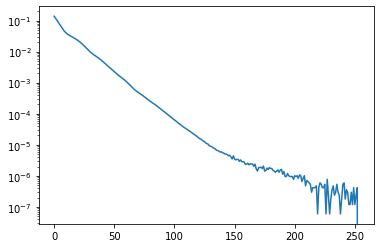

In [31]:
plt.plot(loss_history)
plt.yscale('log')

Let's make a sweep

In [ ]:
%%time

n_qubits = 5
depth = state_tlb(num_qubits)

target_state = random.uniform(random.PRNGKey(0), shape=(2, 2**num_qubits))
target_state = target_state[0]+1j*target_state[1]
target_state_norm_squared = (jnp.abs(target_state.conj()*target_state)).sum()
target_state = target_state/jnp.sqrt(target_state_norm_squared)

best_losses_conn = []
best_losses_chain = []

for d in range(depth):
    anz_conn = Ansatz(n_qubits, 'cz', placements=fill_layers(sequ_layer(anz_conn.n_qubits), d))
    anz_chain = Ansatz(n_qubits, 'cz', placements=fill_layers(chain_layer(anz_chain.n_qubits), d))

    _, loss_history_conn = gradient_descent_learn(
        state_func(anz_conn.unitary, anz_conn.n_angles, anz_conn.n_qubits),
        target_state,
        anz_conn.n_angles,
        target_disc=1e-5)
    
    _, loss_history_chain = gradient_descent_learn(
        state_func(anz_chain.unitary, anz_chain.n_angles, anz_chain.n_qubits),
        target_state,
        anz_chain.n_angles,
        target_disc=1e-5)
    
    best_losses_conn.append(loss_history_conn[-1])
    best_losses_chain.append(loss_history_chain[-1])

In [ ]:
plt.plot(jnp.array(best_losses_conn) - disc2(target_state, target_state), label='conn')
plt.plot(jnp.array(best_losses_chain) - disc2(target_state, target_state), label='chain')
plt.yscale('log')
plt.legend()

In [ ]:
%%time

num_qubits = 7
depth =  state_tlb(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))

target_state = random.uniform(random.PRNGKey(0), shape=(2, 2**num_qubits))
target_state = target_state[0]+1j*target_state[1]
target_state_norm_squared = (jnp.abs(target_state.conj()*target_state)).sum()
target_state = target_state/jnp.sqrt(target_state_norm_squared)

angles_history_conn, loss_history_conn = gradient_descent_learn(state_func(anz.unitary, anz.n_angles, anz.n_qubits),
                       target_state, 
                       anz.n_angles)

In [ ]:
%%time

num_qubits = 7
depth =  state_tlb(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(chain_layer(num_qubits), depth))

target_state = random.uniform(random.PRNGKey(0), shape=(2, 2**num_qubits))
target_state = target_state[0]+1j*target_state[1]
target_state_norm_squared = (jnp.abs(target_state.conj()*target_state)).sum()
target_state = target_state/jnp.sqrt(target_state_norm_squared)

angles_history_chain, loss_history_chain = gradient_descent_learn(state_func(anz.unitary, anz.n_angles, anz.n_qubits),
                       target_state, 
                       anz.n_angles)

In [ ]:
plt.plot(jnp.array(loss_history_conn)-disc2(target_state,target_state), label='conn')
plt.plot(jnp.array(loss_history_chain)-disc2(target_state,target_state), label='chain')
plt.yscale('log')
plt.legend()